In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

%matplotlib inline

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [3]:
# Import our custom code from dataset.py
try:
    from dataset import DeepfakeDataset, IMG_SIZE
except ImportError:
    print("ERROR: Make sure dataset.py is in the same folder as this notebook.")

# This function is just for visualization in this notebook
# It undoes the normalization to show a proper image
def unnormalize_img(tensor_img):
    img = tensor_img.clone().to('cpu')
    # Undo normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img.permute(1, 2, 0) # [C, H, W] -> [H, W, C]
    img = (img * std) + mean
    img = np.clip(img, 0, 1)
    return img

In [4]:
# 1. Load the dataset
# This assumes your data is in the 'data/' folder
print("Loading dataset...")
full_dataset = DeepfakeDataset(data_dir='data/', sequence_length=20)
print(f"Dataset loaded. Found {len(full_dataset)} videos.")

# 2. A 'collate_fn' is needed to filter out failed (None/-1) samples
def collate_fn(batch):
    batch = list(filter(lambda x: x[1] != -1, batch))
    if not batch:
        return torch.tensor([]), torch.tensor([])
    return torch.utils.data.dataloader.default_collate(batch)

# 3. Create a DataLoader
test_loader = DataLoader(
    full_dataset, 
    batch_size=1, 
    shuffle=True, 
    collate_fn=collate_fn, 
    num_workers=0 # Set to 0 for notebook testing, can increase in train.py
)

print("DataLoader created.")

Loading dataset...
Dataset found. Total videos: 12
Dataset loaded. Found 12 videos.
DataLoader created.


Got one batch. Frames shape: torch.Size([1, 20, 3, 224, 224]), Label: 1


C:\Users\shree\AppData\Local\Temp\ipykernel_28652\3198025425.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = (img * std) + mean


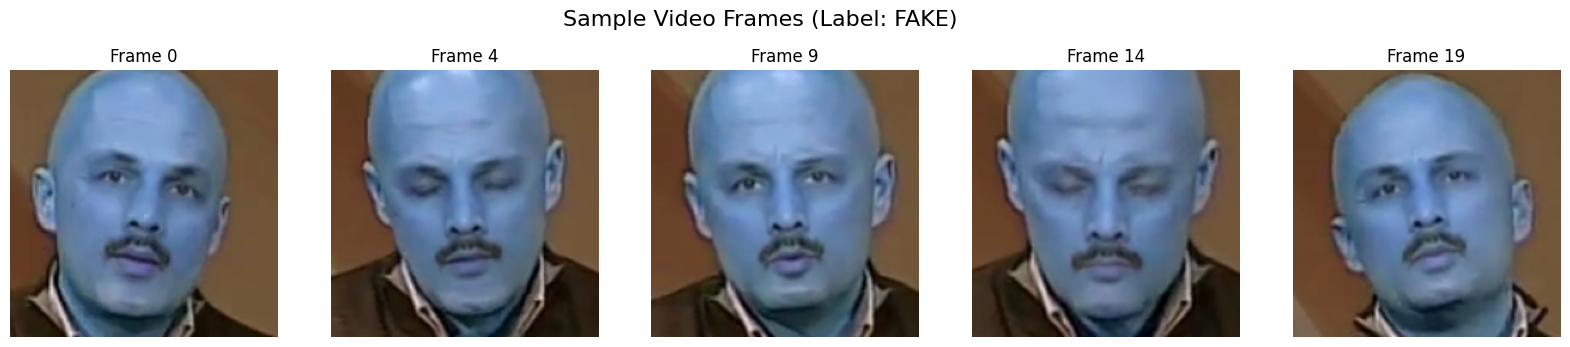

In [5]:
try:
    # 4. Get one batch of data (frames and label)
    frames, label = next(iter(test_loader))

    # frames shape: [B, T, C, H, W]
    # label shape: [B]
    print(f"Got one batch. Frames shape: {frames.shape}, Label: {label.item()}")

    # 5. Plot 5 frames from the sequence
    video_frames = frames[0] # Get the first video (Batch size is 1)
    label_name = 'FAKE' if label.item() == 1 else 'REAL'

    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle(f"Sample Video Frames (Label: {label_name})", fontsize=16)

    # Get 5 evenly spaced frames from the sequence of 20
    plot_indices = np.linspace(0, video_frames.shape[0] - 1, 5, dtype=int)

    for i, ax in enumerate(axes):
        frame_index = plot_indices[i]
        img = unnormalize_img(video_frames[frame_index])
        ax.imshow(img)
        ax.set_title(f"Frame {frame_index}")
        ax.axis('off')
    
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")
    print("\n--- TEST FAILED ---")
    print("This likely means no videos were found or processed.")
    print("1. Make sure you have .mp4 files in 'data/real' and 'data/fake'.")
    print("2. Make sure 'haarcascade_frontalface_default.xml' is in the root folder.")

In [6]:
# Import the model components from model.py
try:
    from model import DeepfakeDetector, FeatureExtractor
    print("Successfully imported model classes from model.py")
except ImportError:
    print("ERROR: Could not import from model.py. Please create and save that file.")

Successfully imported model classes from model.py


In [7]:
# --- Instantiate the Model ---
print("Initializing model...")

# First, get the feature dimension from the CNN extractor
temp_cnn = FeatureExtractor(freeze=True)
FEATURE_DIM = temp_cnn.feature_dim
del temp_cnn # free memory

model = DeepfakeDetector(
    cnn_feature_dim=FEATURE_DIM,
    lstm_hidden_size=512,
    lstm_layers=2,
    num_classes=2
).to(device)

print(f"Model created. CNN Feature dim: {FEATURE_DIM}")
# print(model) # Uncomment to see the full architecture

Initializing model...
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to C:\Users\shree/.cache\torch\hub\checkpoints\resnext50_32x4d-1a0047aa.pth


100.0%


Model created. CNN Feature dim: 2048


In [8]:
# --- Model Smoke Test ---
print("\nRunning model smoke test...")
try:
    # Get a real batch of data from our loader
    frames_batch, labels_batch = next(iter(test_loader))
    frames_batch = frames_batch.to(device)
    labels_batch = labels_batch.to(device)
    
    print(f"Input tensor shape: {frames_batch.shape}")
    
    # --- FORWARD PASS ---
    model.train() # Put model in training mode
    outputs = model(frames_batch)
    # -------------------\n",
    
    print(f"Output tensor shape: {outputs.shape}")
    print(f"Labels tensor shape: {labels_batch.shape}")
    
    print("\n--- SMOKE TEST SUCCESSFUL! --- ")
    print("The model architecture works with the data from dataset.py.")

except Exception as e:
    print(f"\n--- SMOKE TEST FAILED --- ")
    print(f"An error occurred: {e}")
    print("This can happen if your test_loader is empty (no videos found).")


Running model smoke test...
Input tensor shape: torch.Size([1, 20, 3, 224, 224])
Output tensor shape: torch.Size([1, 2])
Labels tensor shape: torch.Size([1])

--- SMOKE TEST SUCCESSFUL! --- 
The model architecture works with the data from dataset.py.
